In [1]:
from datasets import concatenate_datasets, Dataset, DatasetDict
import evaluate
from huggingface_hub import notebook_login, HfFolder
import nltk
import numpy as np
from nltk.tokenize import sent_tokenize
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments
import wandb

2023-07-17 17:09:46.415240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/Caskroom/miniconda/base/envs/sap_sr/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: Required library version not found: libsbitsandbytes_cpu.so. Maybe you need to compile it from source?
CUDA SETUP: Defaulting to libbitsandbytes_cpu.so...
dlopen(/usr/local/Caskroom/miniconda/base/envs/sap_sr/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so, 0x0006): tried: '/usr/local/Caskroom/miniconda/base/envs/sap_sr/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so' (not a mach-o file), '/System/Volumes/Preboot/Cryptexes/OS/usr/local/Caskroom/miniconda/base/envs/sap_sr/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so' (no such file), '/usr/local/Caskroom/miniconda/base/envs/sap_sr/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cpu.so' (not a mach-o file)
CUDA SETUP: Required library version not found: libs

/usr/local/Caskroom/miniconda/base/envs/sap_sr/lib/python3.10/site-packages/bitsandbytes/cextension.py:31: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


In [2]:
df=pd.read_csv('gold_cleaned.csv') #goldstandard data after standardisation (plain extraction)

In [3]:
!git config --global user.email "email id"
!git config --global user.name "username"

In [4]:
wandb.login()

%env WANDB_PROJECT=Flan-T5-gold

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: pranav-tyagi-19 (ankinator). Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=Flan-T5-gold


In [5]:
notebook_login() #hugging face login

In [9]:
#Data split 70% train-20% test-10% valid
train, test = train_test_split(df, test_size=0.2,random_state=42)
train, valid = train_test_split(train, test_size=0.125,random_state=42)

In [10]:
raw_train = Dataset.from_pandas(train)
raw_test = Dataset.from_pandas(test)

In [11]:
raw_train=raw_train.remove_columns('__index_level_0__')
raw_test = raw_test.remove_columns('__index_level_0__')

In [12]:
ds_dict = {'train' : raw_train
    ,'test' : raw_test}

dataset = DatasetDict(ds_dict)

In [13]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'context', 'question'],
        num_rows: 318
    })
    test: Dataset({
        features: ['Unnamed: 0', 'id', 'context', 'question'],
        num_rows: 92
    })
})

In [14]:
valid.to_csv('valid_gold.csv')#held out data used for evaluation later

In [15]:
model_id="google/flan-t5-base"
# Load tokenizer of FLAN-t5-base
tokenizer = AutoTokenizer.from_pretrained(model_id)

In [16]:
# The maximum total input sequence length after tokenization.
#also trucate and pad sequences
tokenized_inputs = concatenate_datasets([dataset["train"], dataset["test"]]).map(lambda x: tokenizer(x["context"], truncation=True), batched=True, remove_columns=["context", "question"])
max_source_length = max([len(x) for x in tokenized_inputs["input_ids"]])
print(f"Max source length: {max_source_length}")

# The maximum total sequence length for target text after tokenization.
tokenized_targets = concatenate_datasets([dataset["train"], dataset["test"]]).map(lambda x: tokenizer(x["question"], truncation=True), batched=True, remove_columns=["context", "question"])
max_target_length = max([len(x) for x in tokenized_targets["input_ids"]])
print(f"Max target length: {max_target_length}")


Map:   0%|          | 0/410 [00:00<?, ? examples/s]

Max source length: 303


Map:   0%|          | 0/410 [00:00<?, ? examples/s]

Max target length: 31


In [17]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = ["Generate question for this text: " + item for item in sample["context"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text_target=sample["question"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(preprocess_function, batched=True, remove_columns=["context", "question", "id"])
print(f"Keys of tokenized dataset: {list(tokenized_dataset['train'].features)}")


Map:   0%|          | 0/318 [00:00<?, ? examples/s]

Map:   0%|          | 0/92 [00:00<?, ? examples/s]

Keys of tokenized dataset: ['Unnamed: 0', 'input_ids', 'attention_mask', 'labels']


In [18]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

In [19]:
nltk.download("punkt")

# Metric
metric = evaluate.load("rouge")

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result


[nltk_data] Downloading package punkt to
[nltk_data]     /home/ma/ma_ma/ma_ptyagi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

In [21]:
# HuggingFace repository id
repository_id = f"{model_id.split('/')[1]}-gold"

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=f"new/{repository_id}",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    predict_with_generate=True,
    fp16=False, # Overflows with fp16
    learning_rate=5e-5,
    num_train_epochs=4,
    # logging & evaluation strategies
    logging_dir=f"new/{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=50,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    # metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="wandb",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
)


In [22]:
# Start training
trainer.train()


/home/ma/ma_ma/ma_ptyagi/.local/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,1.886900,1.373893,62.341900,39.750800,59.056100,59.394300,9.423913
2,1.370700,1.327846,62.068800,39.776000,59.041700,59.407200,9.815217
3,1.194600,1.312046,62.747800,41.472700,59.766900,60.106300,9.739130
4,1.115000,1.307499,62.496900,41.319600,59.714600,59.847100,9.652174


TrainOutput(global_step=320, training_loss=1.3647288501262664, metrics={'train_runtime': 80.3, 'train_samples_per_second': 15.841, 'train_steps_per_second': 3.985, 'total_flos': 517162990436352.0, 'train_loss': 1.3647288501262664, 'epoch': 4.0})

In [23]:
trainer.evaluate()

{'eval_loss': 1.307498574256897,
 'eval_rouge1': 62.4969,
 'eval_rouge2': 41.3196,
 'eval_rougeL': 59.7146,
 'eval_rougeLsum': 59.8471,
 'eval_gen_len': 9.652173913043478,
 'eval_runtime': 4.9735,
 'eval_samples_per_second': 18.498,
 'eval_steps_per_second': 4.624,
 'epoch': 4.0}

In [24]:
wandb.finish()

eval/gen_len,▁█▇▅▅
eval/loss,█▃▁▁▁
eval/rouge1,▄▁█▅▅
eval/rouge2,▁▁█▇▇
eval/rougeL,▁▁█▇▇
eval/rougeLsum,▁▁█▅▅
eval/runtime,▇█▁▃▃
eval/samples_per_second,▂▁█▆▆
eval/steps_per_second,▂▁█▆▆
train/epoch,▁▂▂▄▄▅▆▆▇███
train/global_step,▁▂▂▄▄▅▆▆▇███


In [28]:
tokenizer.save_pretrained(f"new/{repository_id}")

('new/flan-t5-base-gold/tokenizer_config.json',
 'new/flan-t5-base-gold/special_tokens_map.json',
 'new/flan-t5-base-gold/spiece.model',
 'new/flan-t5-base-gold/added_tokens.json',
 'new/flan-t5-base-gold/tokenizer.json')

In [29]:
model.push_to_hub("flan-t5-base-gold")

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/prnv13/flan-t5-base-gold/commit/064ba1ec9c1376b152a692585c26183d4df700e1', commit_message='Upload T5ForConditionalGeneration', commit_description='', oid='064ba1ec9c1376b152a692585c26183d4df700e1', pr_url=None, pr_revision=None, pr_num=None)

In [30]:
tokenizer.push_to_hub("flan-t5-base-gold")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/prnv13/flan-t5-base-gold/commit/e959cbb7b8514c34f9d7e293580d9e03e724a50e', commit_message='Upload tokenizer', commit_description='', oid='e959cbb7b8514c34f9d7e293580d9e03e724a50e', pr_url=None, pr_revision=None, pr_num=None)

Evaluation


In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("prnv13/flan-t5-base-gold")
model = AutoModelForSeq2SeqLM.from_pretrained("prnv13/flan-t5-base-gold")

In [10]:
def run_model(input_string, **generator_args):

  generator_args = {
  "max_length": 512,
  "num_beams": 4,
  "length_penalty": 1.5,
  "no_repeat_ngram_size": 3,
  "early_stopping": True,
  }
  input_string = "generate question for this text: " + input_string
  input_ids = tokenizer.encode(input_string, return_tensors="pt")
  res = model.generate(input_ids, **generator_args)
  output = tokenizer.batch_decode(res, skip_special_tokens=True)
  return output[0]

In [11]:
df = pd.read_csv('valid_gold.csv') #held out data from goldstandard while finetuning the model. 10%

In [12]:
predicted = []
for c in df["context"]:
    predicted.append(run_model(c))

convert model results and questions to the required format for eval

In [13]:
model_results = []
for i, sentence in enumerate(predicted, start=1):
    model_results.append((i, [sentence]))

In [14]:
references = []
for i, sentence in enumerate(df["question"], start=1):
    references.append((i, [sentence]))

In [18]:
from src.evaluation.eval_main import Metrics

metrics = Metrics(save_to_file=True)

result = pd.DataFrame(
    metrics.evaluate(model_output=model_results, references=references),
    index=["T5-gold"]
)
result

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/I585741/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,CASING,rouge1_fmeasure,rouge1_precision,rouge1_recall,rouge2_fmeasure,rouge2_precision,rouge2_recall,rougeL_fmeasure,rougeL_precision,rougeL_recall,...,min_r,avg_f1,max_f1,min_f1,avg_cos_sim,max_cos_sim,min_cos_sim,avg_sem_meteor,max_sem_meteor,min_sem_meteor
T5-gold,46,0.591627,0.626328,0.587136,0.40472,0.428563,0.393332,0.580678,0.612293,0.577933,...,0.0,0.609209,1.0,0.0,0.775797,1.0,0.122963,0.563542,0.998542,0.102041


In [19]:
result.to_csv('result.csv')

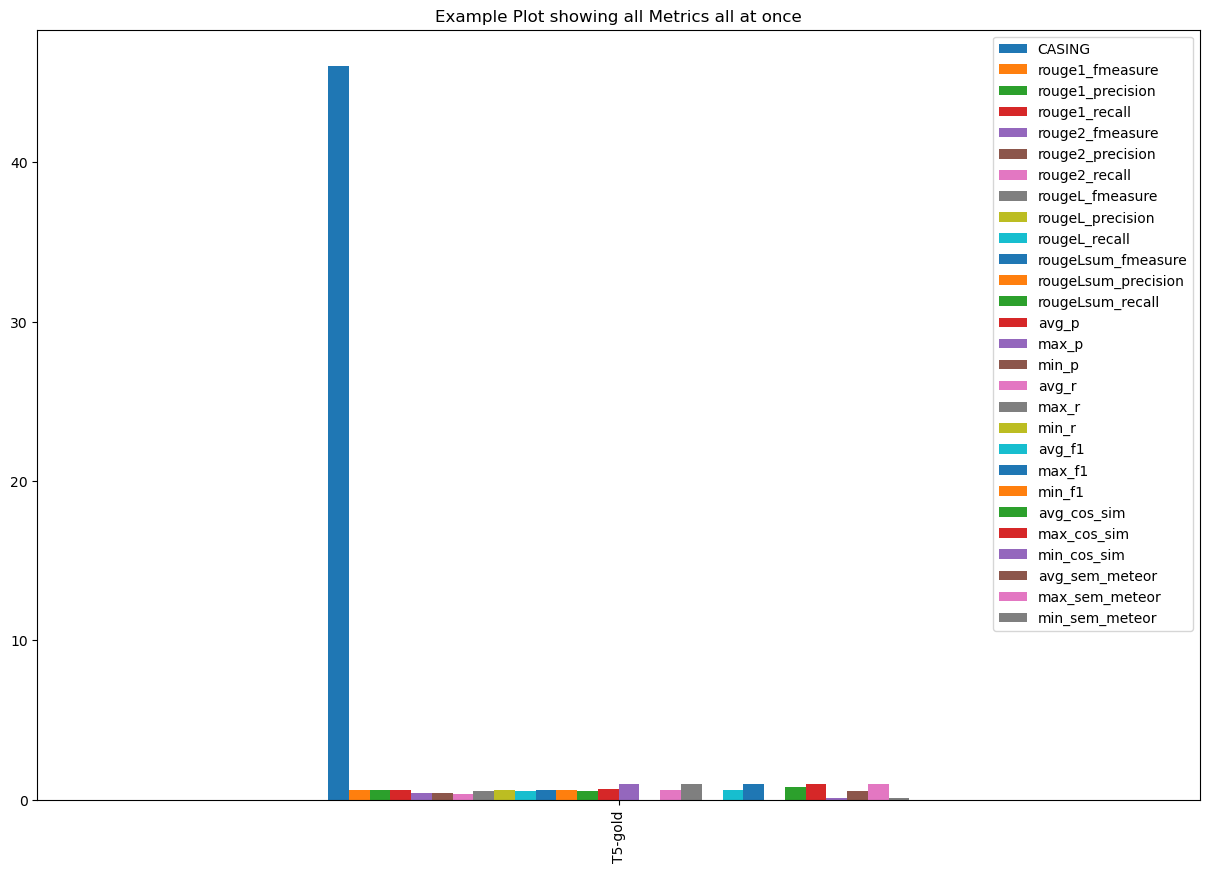

In [20]:
import matplotlib.pyplot as plt
result.plot(kind="bar", figsize=(15,10), title="Example Plot showing all Metrics all at once") # Just for demo purposes. Would not recommend!
plt.show()